# Examples of how to explore data available via PAD API

## Set up the evniroment

### Step 1: Mount Google Drive in Colab
To start, you'll need to connect Google Colab to your Google Drive. This will allow you to access, store, and retrieve files directly from your Drive.

Run the code below to mount your Google Drive. After running the code, a prompt will appear asking for authorization—please follow the steps to grant access.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Step 2: Navigate to the `pad-ml` Folder
Before we clone the GitHub repository, let's ensure we're in the correct working directory. You need to navigate into the `pad-ml` folder where the repository will be cloned.


In [ ]:
%cd /content/drive/My\ Drive/pad-ml/pad-ml-workflow-v2

   ### Step 3: Keep the GitHub Repository Updated
   From time to time, the repository might receive updates. To ensure you have the latest version of the project, you can pull the latest changes using the following command:
   

In [ ]:
!git pull

### Step 4: Import packages

In [ ]:
!pip install -r requirements.txt

In [7]:
#
import os, sys
import ipywidgets as widgets
from IPython.display import display
import numpy as np

module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.utils import *




## **Functionalies **

## ***Projects***

In [ ]:
projects = get_projects()
projects



#### **Tips**
> Use code generation to manipulate data in projects by clicking the "**Generate code with projects**" button in the bottom left of the dataframe.


> You can convert the dataframe into an interactive table by clicking the icon in the top right corner next to the dataframe:

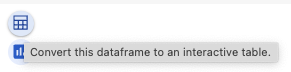



#### **Tips: Returns only the columns that are specified in a list**

> This is helpful when you want to focus on or analyze only certain parts of your data, making it easier to work with large datasets by filtering out unnecessary information.

In [ ]:
columns = ['id','project_name','sample_names','notes']
projects[columns]

#### **Tips: You can also get information from a specific project specifing its `project id`**


In [ ]:
project = get_project(project_id = 11)
project


## ***Card issue types***

In [ ]:
issue_types = get_card_issues()
issue_types

## ***Cards***

In [ ]:

card_info = get_card(card_id=1234)
card_info


In [ ]:
show_card(42279)

In [ ]:
show_cards([21027, 42279])

In [ ]:
card_samples = get_card_samples(sample_id = 53714)


In [ ]:
show_cards_from_df(card_samples)

In [ ]:
project_id = 12
df = get_project_cards(project_id)
show_grouped_cards(df, 'sample_name')

Example: Group by 'quantity' or 'camera_type_1'

In [ ]:

# create_tabs(df, 'quantity')
# create_tabs(df, 'camera_type_1')

In [ ]:
# List of project IDs
project_ids = [11, 12]

# Fetch cards for all the projects
cards = get_project_cards([11, 12])

Advanced selections

In [ ]:

df = df[df['issue.name'].isin(['Leak', 'Rectification', 'Stuck']) ]

leak_df = df[df['issue.name'] == 'Leak']
rectification_df = df[df['issue.name'] == 'Rectification']
stuck_df = df[df['issue.name'] == 'Stuck']

print(f"Leak: {len(leak_df)}")
print(f"Stuck: {len(stuck_df)}")
print(f"Rectification: {len(rectification_df)}")





## ***Neural Networks***

In [ ]:
get_neural_networks()

In [ ]:
get_neural_network(17)

### Get Model Weights

In [13]:
# import os

model_source = get_neural_network(17).weights_url.values[0]

# Extract the filename from the URL
model_filename = os.path.basename(model_source)

# Create the full path where the model will be saved
model_file = os.path.join('./models/', model_filename)

# # Download the model and save it in the ./models/ folder with the original name
!wget {model_source} -O {model_file}

### Inference

In [ ]:
model_file

In [ ]:
card_info = get_card(42279)
show_card(42279)

In [ ]:
#Load png file using the PIL library
#img = Image.open('fhi360_data/catagorize/16_7062.png')
image_url = 'https://pad.crc.nd.edu/' + card_info['processed_file_location'].values[0]
actual_label = card_info['quantity'].values[0]

labels = ['0', '100', '20', '50', '80']

# Read the image from the URL
img = read_img(image_url)

#crop image to get active area
img = img.crop((71, 359, 71+636, 359+490))

#for square images
size = (454, 454)
img = img.resize((size),Image.BICUBIC)#, Image.ANTIALIAS)

#reshape the image as numpy
#im = np.asarray(img).flatten().reshape(1, HEIGHT_INPUT, WIDTH_INPUT, DEPTH)

HEIGHT_INPUT, WIDTH_INPUT, DEPTH = (454, 454,3)

#reshape the image as numpy
im = np.asarray(img).flatten().reshape(1, HEIGHT_INPUT, WIDTH_INPUT, DEPTH).astype(np.float32)

# Load the TFLite model and allocate tensors.
# model_file = 'lite_models/' + arch + experiment + '_v1p0'

interpreter = tf.lite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
#print("input", input_details[0])

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], im)

# predict
interpreter.invoke()

# result
result = interpreter.get_tensor(output_details[0]['index'])
# print("Result", np.argmax(result[0]), result[0], tf.nn.softmax(result[0]))

num_label = np.argmax(result[0])
print("Prediction: ", labels[num_label])
probability = tf.nn.softmax(result[0])[num_label].numpy()
print("Probability: ", probability)

# energy
energy = tf.reduce_logsumexp(result[0], -1)
print("Energy: ", energy.numpy())

# expected_label =
print("Actual label: ", actual_label)